**Modelo creado para usar con la libreria segmentation-models**

In [1]:
#Informacion sobre la GPU del entorno
#Codigo proporcionado en documentacion Google Colab

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


Wed May 20 20:33:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#Informacion sobre memoria disponible
#Codigo proporcionado en documentacion Google Colab

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
#instalamos la libreria segmentation-models
!pip install segmentation-models==1.0.0

In [4]:
import os
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from segmentation_models import Unet
from segmentation_models.metrics import IOUScore
from segmentation_models.losses import JaccardLoss
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
#tamaño del batch, mas de 2 puede dar OOM
BATCH = 2

#BACKBONE disponbles https://github.com/qubvel/segmentation_models#models-and-backbones
#Se han realizado pruebas con: Resnet50, Resnet34, VGG16, VGG19, inceptionv3, efficientnetb3, mobilenetv2
BACKBONE = 'vgg19'


In [6]:
#Montamos nuestro entorno del drive para tener acceso a los ficheros
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Path de imagenes entrenamiento
path_train_im = '/content/drive/My Drive/Colab Notebooks/dataset/aerial/train_tiles/tile_im/'
path_train_gt = '/content/drive/My Drive/Colab Notebooks/dataset/aerial/train_tiles/tile_gt/'

#Patch de imagenes validacion 
path_val_im = '/content/drive/My Drive/Colab Notebooks/dataset/aerial/val_tiles/tile_im/'
path_val_gt = '/content/drive/My Drive/Colab Notebooks/dataset/aerial/val_tiles/tile_gt/'

[  0 255]
(384, 384)


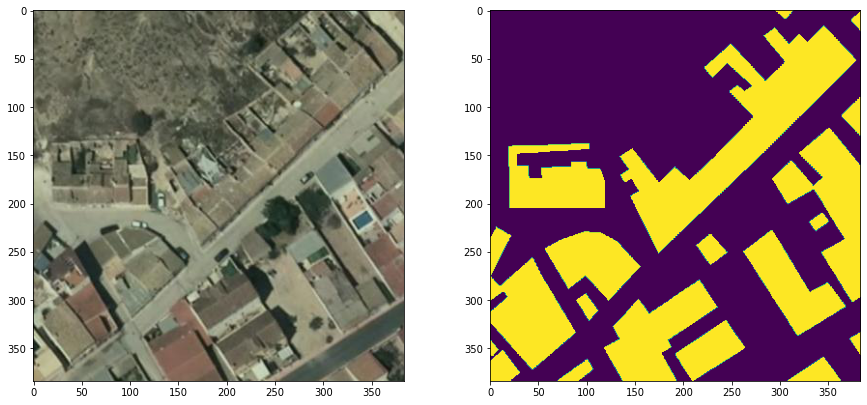

In [8]:
#Comprobamos que tenemos acceso a lass imagenes
#imagen RGB
foto = Image.open(path_train_im + 'tile_im/681051.12_4238267.56_681147.12_4238363.56.jpg')
#Imagen segmentada
mascara = Image.open(path_train_gt + 'tile_gt/681051.12_4238267.56_681147.12_4238363.56.png')
mascara = np.array(mascara)
#Valores unicos imagen segmentada
print(np.unique(mascara))
#Dimensiones imagen segmentada
print(mascara.shape)
#Mostramos las imagenes
plt.figure(figsize=(15,15))
#posicion 1  imagen RGB
plt.subplot(221)
plt.imshow(foto)
#Posicion 2 imagen segmentada
plt.subplot(222)
plt.imshow(mascara)

In [9]:
#Generacion Imagenes entrenamiento

#Establecemos semilla numeros aleatorios
seed = 164

#Usamos ImageDataGenerator para generar lotes de imagenes normalizadas   
image_datagen = ImageDataGenerator(rescale = 1./255)
mask_datagen = ImageDataGenerator(rescale = 1./255)

#imagenes entrenamiento,Toma la ruta a un directorio y genera lotes de datos aumentados.
img_train = image_datagen.flow_from_directory(
    #path imagenes entrenamiento rgb
    path_train_im,
    #resolucion de las imagenes
    target_size = (384,384,),
    #usamos batch 2, con valores mas altos puede darnos OOM
    batch_size = BATCH,
    #Determina el tipo de matrices de etiquetas que se devuelven, no indicamos ninguna
    class_mode = None,
    #semilla
    seed = seed)

#imagenes segmentadas,Toma la ruta a un directorio y genera lotes de datos aumentados.
mask_train = mask_datagen.flow_from_directory(
    #path imagenes entrenamiento segmentadas
    path_train_gt,
    #resolcuion de las imagenes
    target_size = (384,384),
    #usamos batch 2, con valores mas altos puede darnos OOM
    batch_size = BATCH,
    #Determina el tipo de matrices de etiquetas que se devuelven,con None devuelve solo la imagen
    class_mode = None,
    #Al tener etiquetas binarias le indicamos grayscale (1 canal)
    color_mode = 'grayscale',
    #semilla
    seed=seed
)

#combinamos los datos obtenidos de los dos generadores
train_gen=zip(img_train,mask_train)

Found 3200 images belonging to 1 classes.
Found 3200 images belonging to 1 classes.


In [10]:
#generacion imagenes validacion

#Usamos ImageDataGenerator para generar lotes de imagenes normalizadas   
val_image_datagen = ImageDataGenerator(rescale = 1./255)
val_mask_datagen = ImageDataGenerator(rescale = 1./255)

#iamgenes RGB para validacion
img_val = val_image_datagen.flow_from_directory(
    #path de las imagenes validacion RGB
    path_val_im,
    #resolucion de lass imagenes
    target_size=(384,384,),
    #Determina el tipo de matrices de etiquetas que se devuelven,con None devuelve solo la imagen
    class_mode=None,
    #Obtenemos los datos en orden alfanumerico
    shuffle=False
)

mask_val = mask_datagen.flow_from_directory(
    #path de las imagenes validacion segmentadas
    path_val_gt,
    #resolucion imagenes
    target_size=(384,384,),
    #Determina el tipo de matrices de etiquetas que se devuelven,con None devuelve solo la imagen
    class_mode=None,
    #Al tener etiquetas binarias le indicamos grayscale (1 canal)
    color_mode='grayscale',
    #Obtenemos los datos en orden alfanumerico
    shuffle=False
)

#combinamos los datos obtenidos de los dos generadores
val_gen=zip(img_train,mask_train)

Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.


In [0]:
#Estos callbacks los he usado en pruebas de mas de 300 epochs

#Earlystop para hacer parada si val_loss no mejoraba en 15 epochs
#val_loss es bastante sensible y no ha dado buen resultado

early = EarlyStopping(monitor = 'val_loss',
                              #Contamos como mejora cualquier cambio
                              min_delta = 0,
                              #Numero de epochs que esperamos
                              patience = 15,
                              verbose = 0, 
                              #en modo auto la dirección se infiere automáticamente
                              mode = 'auto',
                              #Recupera el epoch con mejor valor
                              restore_best_weights = True)

#Guardamos los chechpoints cada vez que se mejora el val_accurracy
#En caso de interrupcion del entorno podemos recuperar el modelo 
#se guarda el fichero con el numero de epoch y valor de val_accuracy
filepath = "/content/drive/My Drive/Colab Notebooks/temp/epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             #se monioriza val_acurracy
                             monitor = 'val_accuracy', 
                             #Modo 1
                             verbose = 1, 
                             #No se sobreescribira el ultimo mejor modelo
                             save_best_only = True, 
                             #para val_accuraccy buscamos los valores maximos
                             mode = 'max')

#Lista callbacks
callbacks_list = [checkpoint,early]

In [12]:
#Modelo Unet
modelo=Unet(
    #VGG19
    backbone_name = BACKBONE,
    #Clases=1 , las etiquetas son binarias
    classes = 1,
    #Activacion sigmoid para segmentacion binaria
    activation = 'sigmoid',
    #cargamos los pesos de imagenet
    encoder_weights = 'imagenet')

80142336/80134624 [==============================] - 1s 0us/step


In [0]:
#compilamos el modelo
#metrica IOU
metric = IOUScore()
#perdida
loss = JaccardLoss()
modelo.compile(
    #optimizador Adam
    'Adam',
    #Funcion perdida Jaccardloss
    loss = loss,
    #matrica accuraccy y IOUSCore
    metrics = ['accuracy', metric])


In [14]:

historia = modelo.fit_generator(
    #datos entrenamiento
    train_gen,
    #pasos por epoca 1600*2 = 3200 imagenes entrenamiento
    steps_per_epoch = 1600,
    #200 epcohs
    epochs = 200,
    #datos validacion
    validation_data = val_gen,
    #pasos validacion 400*2 = 800 imagenes validacion
    validation_steps = 400)
    #en este modelo no vamos a usar los callbacks
    #callbacks=callbacks_list)

Epoch 1/200
1600/1600 [==============================] - 1852s 1s/step - loss: 0.6680 - accuracy: 0.8189 - iou_score: 0.3320 - val_loss: 0.7923 - val_accuracy: 0.8488 - val_iou_score: 0.3840
Epoch 2/200
1600/1600 [==============================] - 203s 127ms/step - loss: 0.5827 - accuracy: 0.8674 - iou_score: 0.4173 - val_loss: 0.3892 - val_accuracy: 0.8900 - val_iou_score: 0.3493
Epoch 3/200
1600/1600 [==============================] - 203s 127ms/step - loss: 0.5142 - accuracy: 0.8890 - iou_score: 0.4858 - val_loss: 0.4808 - val_accuracy: 0.8920 - val_iou_score: 0.4767
Epoch 4/200
1600/1600 [==============================] - 203s 127ms/step - loss: 0.4738 - accuracy: 0.9038 - iou_score: 0.5262 - val_loss: 0.4950 - val_accuracy: 0.8771 - val_iou_score: 0.4832
Epoch 5/200
1600/1600 [==============================] - 203s 127ms/step - loss: 0.4371 - accuracy: 0.9132 - iou_score: 0.5629 - val_loss: 0.2975 - val_accuracy: 0.9142 - val_iou_score: 0.5389
Epoch 6/200
1600/1600 [==============

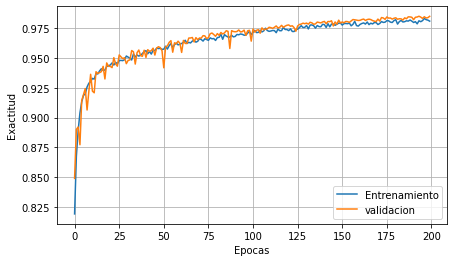

In [15]:
#Grafico accuracy y val_acurracy
plt.figure(figsize = (7, 4))
plt.plot(historia.history['accuracy'])
plt.plot(historia.history['val_accuracy'])
plt.xlabel('Epocas')
plt.ylabel('Exactitud')
plt.legend(['Entrenamiento','validacion'])
plt.grid()

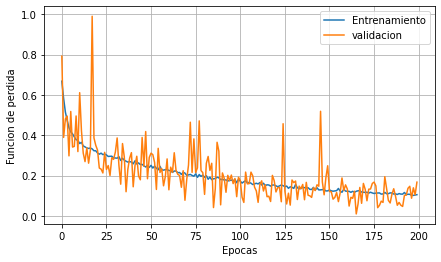

In [16]:
#Grafico lossy y val_loss
plt.figure(figsize=(7,4))
plt.plot(historia.history['loss'])
plt.plot(historia.history['val_loss'])
plt.xlabel('Epocas')
plt.ylabel('Funcion de perdida')
plt.legend(['Entrenamiento','validacion'])
plt.grid()

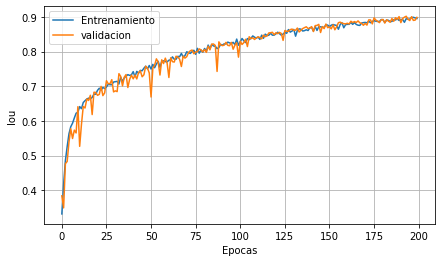

In [17]:
#grafico iou_score y val_iou_score
plt.figure(figsize=(7,4))
plt.plot(historia.history['iou_score'])
plt.plot(historia.history['val_iou_score'])
plt.xlabel('Epocas')
plt.ylabel('Iou')
plt.legend(['Entrenamiento','validacion'])
plt.grid()

In [0]:
# Guardamos el modelo backbone_batchsize_epoch_loss
modelo.save('/content/drive/My Drive/Colab Notebooks/vgg19_2_200_iou.h5')

In [19]:
#predecimos el conjunto de imagenes para la validacion, se obtiene una probabilidad entr 0 y 1 para casa pixel de ser construccion
prob_val_unet = modelo.predict_generator(img_val)

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


In [0]:
#creamos un array de ceros con las dimensiones de la prediccion
y_pred_val_unet = np.zeros(prob_val_unet.shape)

#Los valores de preccion mayor que 0.5 los consideramos construccion y les asignamos mascara 255
#este valor se puede cambiar si queremos aumentar o disminuir la probabilidad para ser construccion
y_pred_val_unet[prob_val_unet > 0.5] = 255

In [21]:
#Calculamos lass metricas del modelo de validacion con evaluate_generator

val_loss,val_acc,val_iou=modelo.evaluate_generator(
    #conjunto datos validacion
    val_gen,
    #pasos = total datos/ batch_size
    steps = int(len(img_val) / BATCH)
)
#Excatitud validacion
print('Exactitud: ',format(100*val_acc,'.2f'),'%')
#IoU validacion
print('IoU: ',format(100*val_iou,'.2f'),'%')

Exactitud:  98.10 %
IoU:  89.42 %


In [0]:
#Guardamos las mascaras de la validacion en array x,y que usaremos en la visualizacion de imagenes
#Imagenes RGB
x_val_unet = []
#Mascara real
y_val_unet = []

for i in range(len(img_val)):
    y_val_unet.extend(mask_val[i])
    x_val_unet.extend(img_val[i])

In [0]:
## Mostramos algunos ejemplos de la prediccion

Text(0.5, 1.0, 'Mascara predicha')

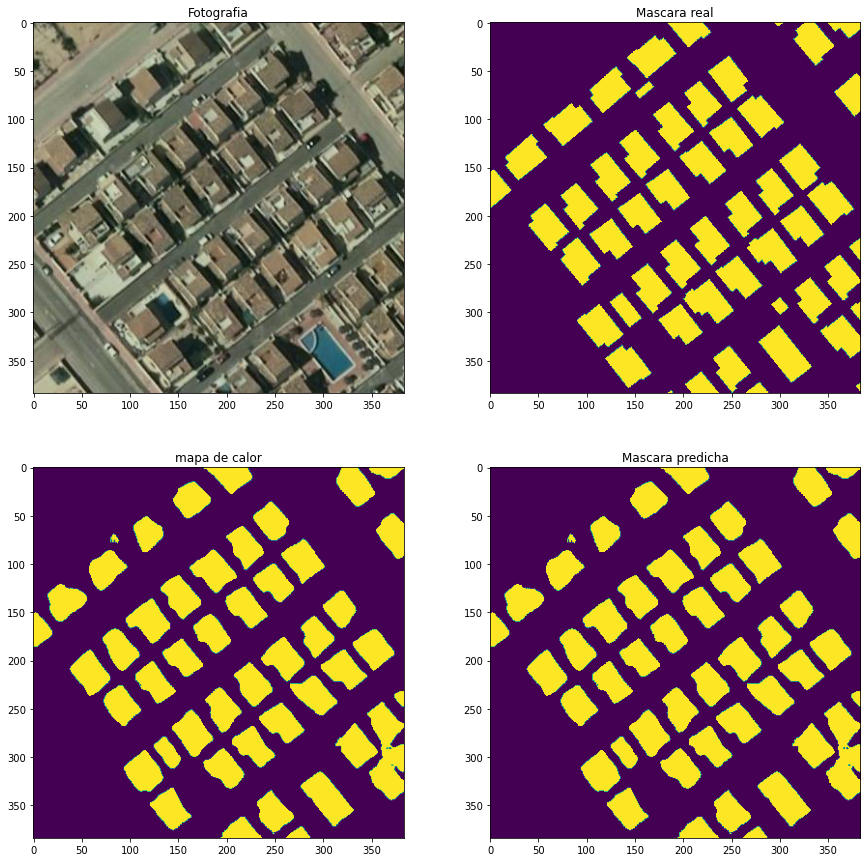

In [24]:
ind=233

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(x_val_unet[ind])
plt.title('Fotografia')

plt.subplot(222)
plt.imshow(y_val_unet[ind][:,:,0])
plt.title('Mascara real')

plt.subplot(223)
plt.imshow(prob_val_unet[ind,:,:,0])
plt.title('mapa de calor')

plt.subplot(224)
plt.imshow(y_pred_val_unet[ind,:,:,0])
plt.title('Mascara predicha')

Text(0.5, 1.0, 'Mascara predicha')

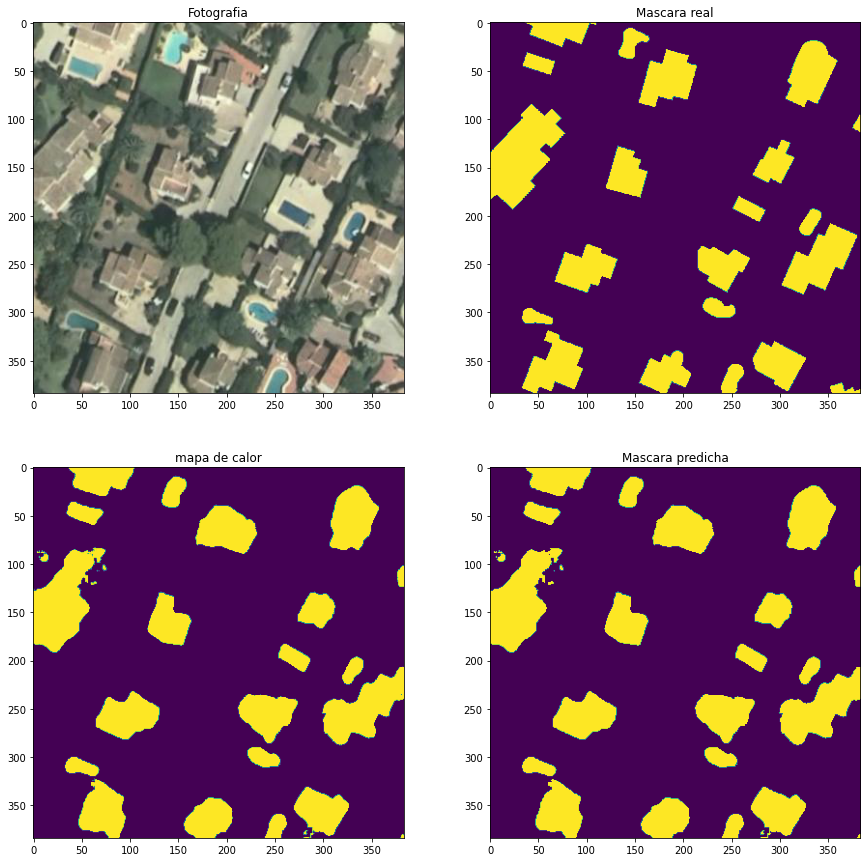

In [25]:
ind=799

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(x_val_unet[ind])
plt.title('Fotografia')

plt.subplot(222)
plt.imshow(y_val_unet[ind][:,:,0])
plt.title('Mascara real')

plt.subplot(223)
plt.imshow(prob_val_unet[ind,:,:,0])
plt.title('mapa de calor')

plt.subplot(224)
plt.imshow(y_pred_val_unet[ind,:,:,0])
plt.title('Mascara predicha')

Text(0.5, 1.0, 'Mascara predicha')

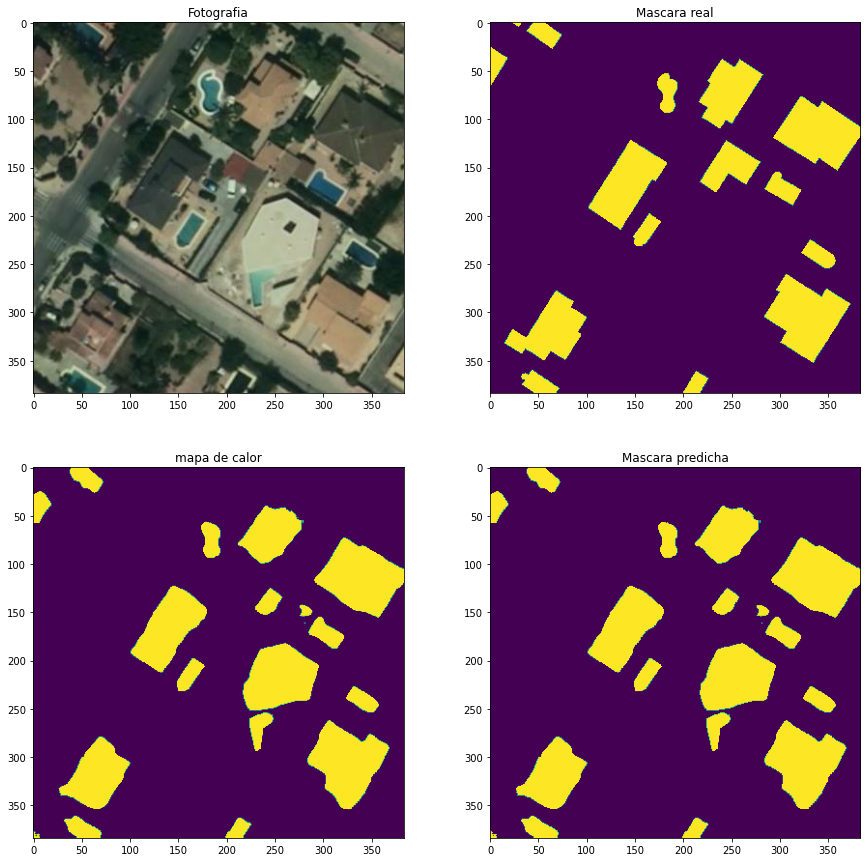

In [26]:
ind=500

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(x_val_unet[ind])
plt.title('Fotografia')

plt.subplot(222)
plt.imshow(y_val_unet[ind][:,:,0])
plt.title('Mascara real')

plt.subplot(223)
plt.imshow(prob_val_unet[ind,:,:,0])
plt.title('mapa de calor')

plt.subplot(224)
plt.imshow(y_pred_val_unet[ind,:,:,0])
plt.title('Mascara predicha')

Text(0.5, 1.0, 'Mascara predicha')

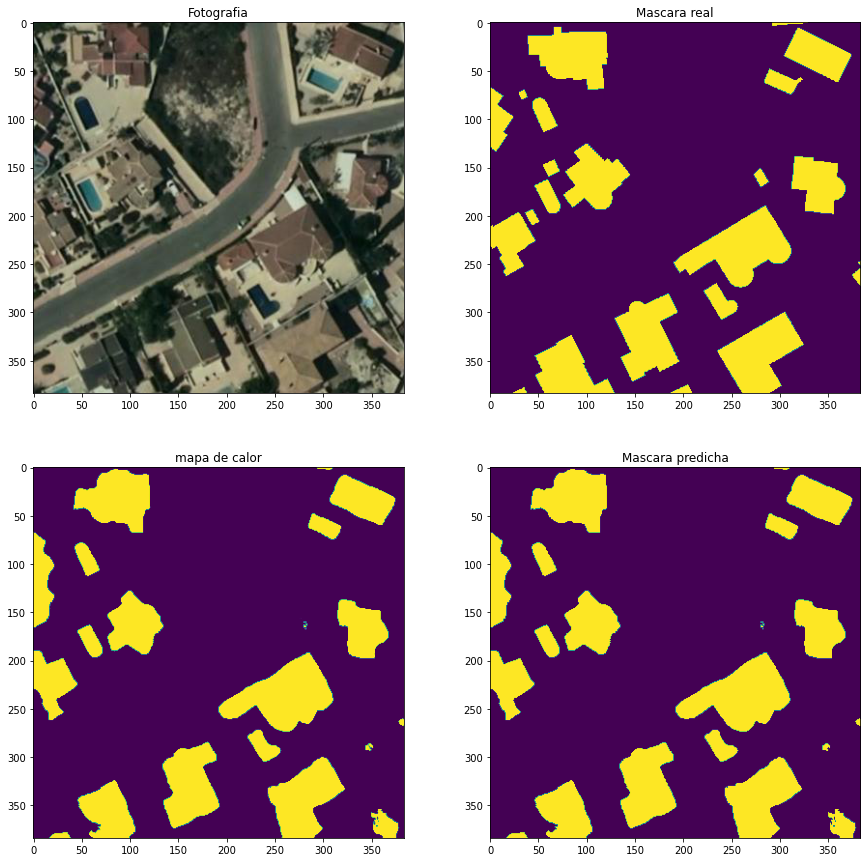

In [27]:
ind=201

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(x_val_unet[ind])
plt.title('Fotografia')

plt.subplot(222)
plt.imshow(y_val_unet[ind][:,:,0])
plt.title('Mascara real')

plt.subplot(223)
plt.imshow(prob_val_unet[ind,:,:,0])
plt.title('mapa de calor')

plt.subplot(224)
plt.imshow(y_pred_val_unet[ind,:,:,0])
plt.title('Mascara predicha')

Text(0.5, 1.0, 'Mascara predicha')

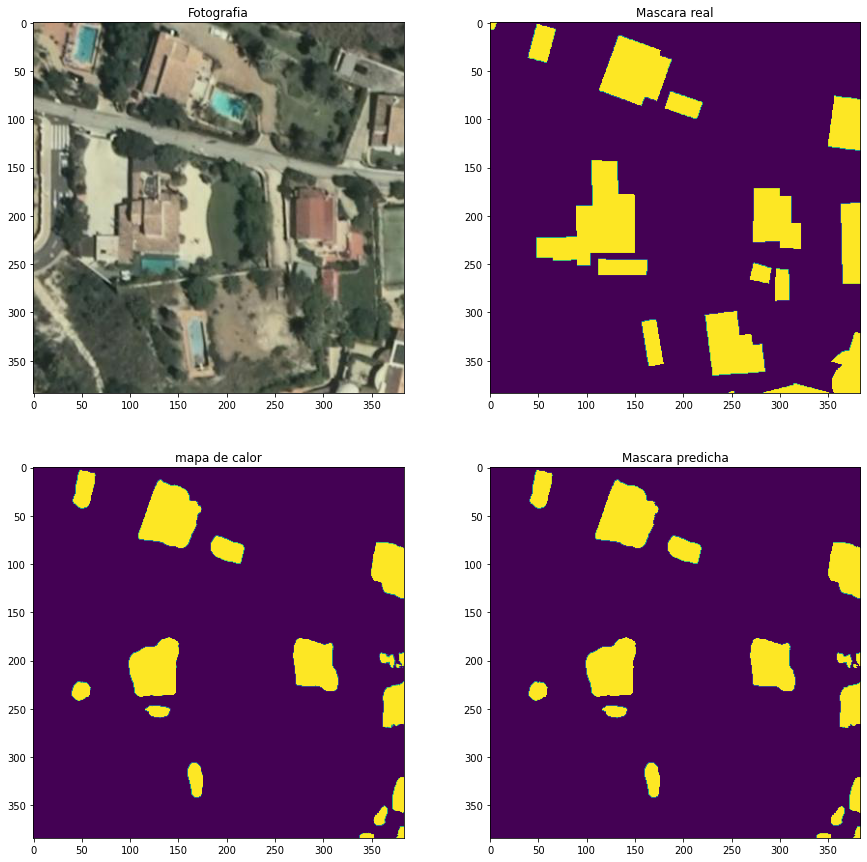

In [28]:
ind=775

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(x_val_unet[ind])
plt.title('Fotografia')

plt.subplot(222)
plt.imshow(y_val_unet[ind][:,:,0])
plt.title('Mascara real')

plt.subplot(223)
plt.imshow(prob_val_unet[ind,:,:,0])
plt.title('mapa de calor')

plt.subplot(224)
plt.imshow(y_pred_val_unet[ind,:,:,0])
plt.title('Mascara predicha')